In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from PIL import Image

from utils.plotting import showFlow, overlaySegment
from utils.encoding import dice_coeff
import time

import os
# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f29b48087f0>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
# check if the overlay works
def overlaySegment(gray1,seg1,flag=False):
    H, W = seg1.squeeze().size()
    colors=torch.FloatTensor([0,0,0,199,67,66,225,140,154,78,129,170,45,170,170,240,110,38,111,163,91,235,175,86,202,255,52,162,0,183]).view(-1,3)/255.0
    segs1 = labelMatrixOneHot(seg1.unsqueeze(0),3)

    seg_color = torch.mm(segs1.view(3,-1).t(),colors[:3,:]).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy())
        plt.show()
    return overlay
def labelMatrixOneHot(segmentation, label_num):
    B, H, W = segmentation.size()
    values = segmentation.view(B,1,H,W).expand(B,label_num,H,W).to(segmentation.device)
    linspace = torch.linspace(0, label_num-1, label_num).long().view(1,label_num,1,1).expand(B,label_num,H,W).to(segmentation.device)
    matrix = (values.float()==linspace.float()).float().to(segmentation.device)
    for j in range(2,matrix.shape[1]):
        matrix[0,j,:,:] = matrix[0,j,:,:]
    return matrix

In [15]:
W,H = (150,150)
o_m = H//4 +1
o_n = W//4 +1
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)#.cuda()
disp_range = 0.25#0.25
disp_hw = 5
displace_range = 11

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)#.cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    
    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:4043: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [4]:
path_to_state_dict = "models/Experiment_1/obel16_mix_100E_28_12_21-10-41.pth"
model_classic = OBELISK2d(16)
model_classic.load_state_dict(torch.load(path_to_state_dict))
model_classic.eval()#.cuda()

path_to_state_dict = "models/Experiment_2/obel16_ensemble_13_10_21-21-30.pth"
model_kc = OBELISK2d(16)
model_kc.load_state_dict(torch.load(path_to_state_dict))
model_kc.eval()#.cuda()

path_to_state_dict = "models/Experiment_3/27_10_21-10-59/student_16_1.pth"
model_dml = OBELISK2d(16)
model_dml.load_state_dict(torch.load(path_to_state_dict))
model_dml.eval()#.cuda()

model_soft = OBELISK2d(16)
model_soft.load_state_dict(torch.load("models/Experiment_2/obel16_ensemble_soft_27_10_21-13-26.pth"))
model_soft.eval()#.cuda()

OBELISK2d(
  (layer0): Conv2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [38]:
def pdd_warp(model, fixed, moving, fixed_seg, moving_seg):
    model.eval()
    
    #start = time.time()
    feat1 = model(moving.unsqueeze(0).unsqueeze(0))#.cuda())
    feat2 = model(fixed.unsqueeze(0).unsqueeze(0))#.cuda())
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, moving, displace_range, H//4 +1, W//4 +1)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150), mode='bicubic')
    #end = time.time()
    #run_time = round(end-start, 4)
    
    identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)
    warped_student_seg = F.grid_sample(fixed_seg.unsqueeze(0).unsqueeze(0).float(),identity+flow.cpu().permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    return warped_student_seg, 200, flow

In [40]:
path_to_data = "/share/data_ultraschall/compressions"
ids = [157, 384, 717, 1097, 1150, 1314, 58, 115, 2709, 2713,4814, 2199,545, 216, 610,341,526,12,124,1778,195,379,327,384,2033,797]
prob_id = 384
#overall_classic_dice = []
#overall_kc_dice = []
#overall_dml_dice = []
#overall_soft_dice = []

print(prob_id)
frame_path = os.path.join(path_to_data,str(prob_id),'frames')
seg_path = os.path.join(path_to_data,str(prob_id),'segmentations','1')

frame_list = []
for frame in os.listdir(frame_path):
    frame_list.append(os.path.join(frame_path,frame))
frame_list.sort()

seg_list = []
for seg in os.listdir(seg_path):
    seg_list.append(os.path.join(seg_path,seg))
seg_list.sort()

assert len(frame_list) == len(seg_list)
frames = torch.zeros([len(frame_list), 150,150])
segs = torch.zeros([len(frame_list), 150,150])
for i in range(len(frame_list)):
    frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255
    segs[i] = (torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100)

landmarks = pd.read_csv('landmarks.csv')
landmarks[landmarks['Id'].isin(ids)]

last_segment_available = np.fromstring(landmarks[landmarks['Id']== prob_id]['Start Frames'].iat[0].strip(']['), sep=',', dtype=int)[0]

384


In [41]:
distance_between_frames = 6

classic_segs = torch.zeros(segs.shape)
kc_segs = torch.zeros(segs.shape)
dml_segs = torch.zeros(segs.shape)

classic_dice = torch.zeros(frames.shape[0],2)
kc_dice = torch.zeros(frames.shape[0],2)
dml_dice = torch.zeros(frames.shape[0],2)

classic_field = torch.zeros(frames.shape[0], 2, frames.shape[1], frames.shape[2])

for i, frame in enumerate(frames):

    # skipp first X frames
    if i < distance_between_frames:
        continue
    
    if i-distance_between_frames <= last_segment_available:
        fixed = torch.clone(frames[i- distance_between_frames])
        fixed_seg = torch.clone(segs[i-distance_between_frames])
    
    if i-distance_between_frames > last_segment_available:
        fixed = torch.clone(frames[last_segment_available])
        fixed_seg = torch.clone(segs[last_segment_available])
    
    
    moving = torch.clone(frames[i])
    moving_seg = torch.clone(segs[i])


    # LABELLOSS
    pdd_seg, run_time_pdd, flowfield = pdd_warp(model_classic, fixed, moving, fixed_seg, moving_seg)
    classic_segs[i] = pdd_seg.detach()
    classic_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)
    classic_field[i] = flowfield.detach()

    # KC
    #pdd_seg, run_time_pdd, _ = pdd_warp(model_kc, fixed, moving, fixed_seg, moving_seg)
    #kc_segs[i] = pdd_seg.detach()
    #kc_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)

    # DML
    #pdd_seg, run_time_pdd, _ = pdd_warp(model_dml, fixed, moving, fixed_seg, moving_seg)
    #dml_segs[i] = pdd_seg.detach()
    #dml_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)

     # SOFT
    #pdd_seg, run_time_pdd, _ = pdd_warp(model_soft, fixed, moving, fixed_seg, moving_seg)
    #soft_segs[i] = pdd_seg.detach()
    #soft_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)


/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


# Show Comparison in Video

In [42]:
print("Vein: ", classic_dice[:,0].mean(), classic_dice[:,0].var())
print("Artery: ", classic_dice[:,1].mean(), classic_dice[:,1].var())
print("Overall: ", classic_dice.mean(), classic_dice.var())

Vein:  tensor(0.2162) tensor(0.0962)
Artery:  tensor(0.3211) tensor(0.1329)
Overall:  tensor(0.2686) tensor(0.1170)


<IPython.core.display.Javascript object>


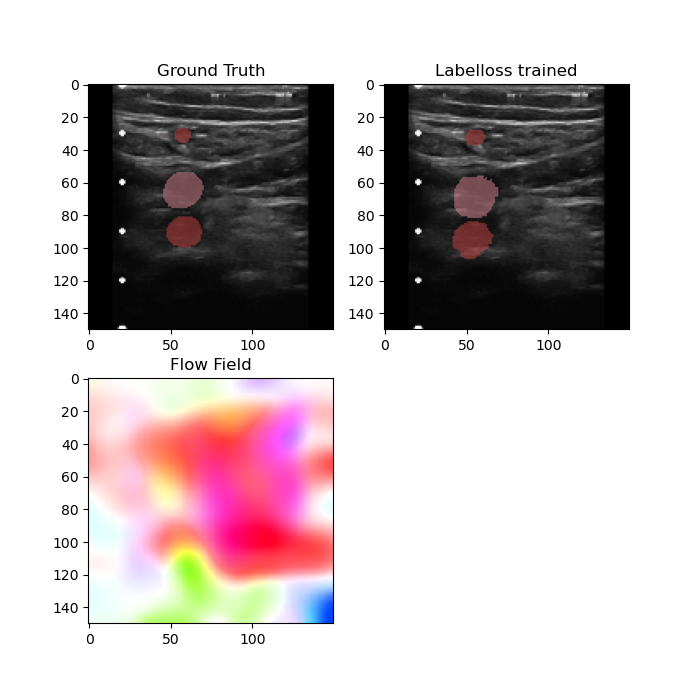

/home/nicke/MasterThesis/utils/plotting.py:15: RuntimeWarning: invalid value encountered in true_divide
  rho = np.clip(rho/np.percentile(rho, 99),0,1)


In [43]:
%matplotlib notebook

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)


ax1.set_title("Ground Truth")
ax2.set_title('Labelloss trained')
ax3.set_title('Flow Field')
#ax4.set_title('DML trained')


lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_classic = overlaySegment(frames[i], classic_segs[i].squeeze())
    flow_vis = showFlow(classic_field[i])
    #overlay_kc = overlaySegment(frames[i], kc_segs[i].squeeze())
    #overlay_dml = overlaySegment(frames[i], dml_segs[i].squeeze())
    #overlay_soft = overlaySegment(frames[i], soft_segs[i].squeeze())
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    classic_image = ax2.imshow(overlay_classic, animated=True)
    flow_img = ax3.imshow(flow_vis, animated=True)
    #kc_image = ax3.imshow(overlay_kc, animated=True)
    #dml_image = ax4.imshow(overlay_dml, animated=True)
    #soft_image = ax4.imshow(overlay_soft, animated=True)
    
    lines.append([ground_truth_image, classic_image, flow_img])
    
ani = animation.ArtistAnimation(fig,lines,interval=100,blit=True)
plt.show()

In [44]:
ani.save(f'flowfield_{prob_id}.mp4')

<IPython.core.display.Javascript object>


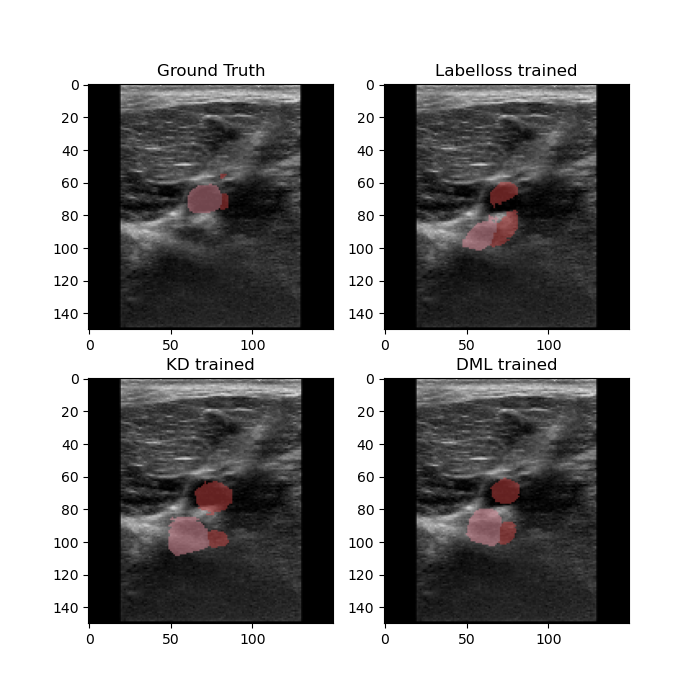

In [19]:
%matplotlib notebook

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.set_title("Ground Truth")
ax2.set_title('Labelloss trained')
ax3.set_title('KD trained')
ax4.set_title('DML trained')


lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_classic = overlaySegment(frames[i], classic_segs[i].squeeze())
    overlay_kc = overlaySegment(frames[i], kc_segs[i].squeeze())
    overlay_dml = overlaySegment(frames[i], dml_segs[i].squeeze())
    #overlay_soft = overlaySegment(frames[i], soft_segs[i].squeeze())
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    classic_image = ax2.imshow(overlay_classic, animated=True)
    kc_image = ax3.imshow(overlay_kc, animated=True)
    dml_image = ax4.imshow(overlay_dml, animated=True)
    #soft_image = ax4.imshow(overlay_soft, animated=True)
    
    lines.append([ground_truth_image, classic_image, kc_image,dml_image])
    
ani = animation.ArtistAnimation(fig,lines,interval=100,blit=True)
plt.show()

In [20]:
ani.save(f'compare_models_on_{prob_id}.mp4')

# Generate Video of ground truth and No seg

<IPython.core.display.Javascript object>


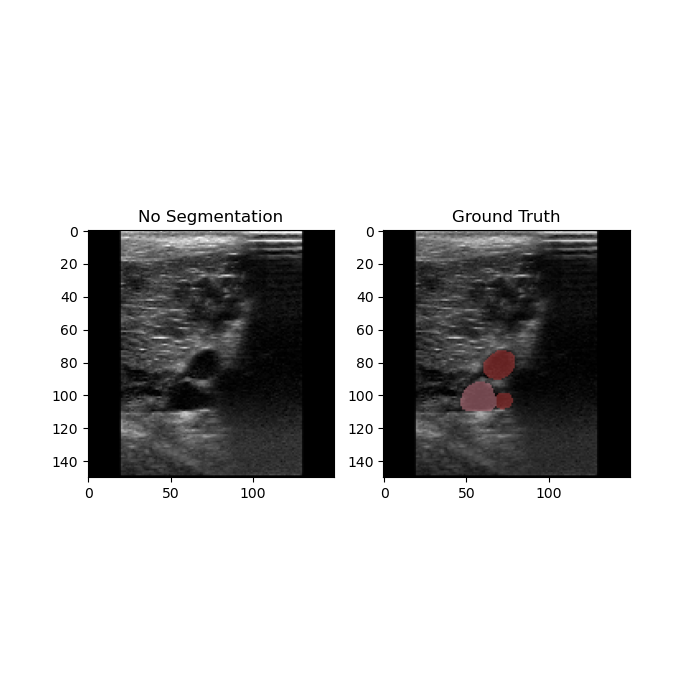

In [10]:
%matplotlib notebook

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('No Segmentation')
ax2.set_title('Ground Truth')


lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    #overlay_classic = overlaySegment(frames[i], classic_segs[i].squeeze())
    #overlay_kc = overlaySegment(frames[i], kc_segs[i].squeeze())
    #overlay_dml = overlaySegment(frames[i], dml_segs[i].squeeze())
    #overlay_soft = overlaySegment(frames[i], soft_segs[i].squeeze())
    
    ground_truth_image = ax2.imshow(overlay_ground, animated=True)
    no_seg = ax1.imshow(frames[i], cmap='gray', animated=True)
    #classic_image = ax1.imshow(overlay_classic, animated=True)
    #kc_image = ax2.imshow(overlay_kc, animated=True)
    #dml_image = ax3.imshow(overlay_dml, animated=True)
    #soft_image = ax4.imshow(overlay_soft, animated=True)
    
    lines.append([no_seg, ground_truth_image])
    
ani = animation.ArtistAnimation(fig,lines,interval=100,blit=True)
plt.show()

In [11]:
ani.save(f'gt_and_no_seg{prob_id}.mp4')

# All in one Video

<IPython.core.display.Javascript object>


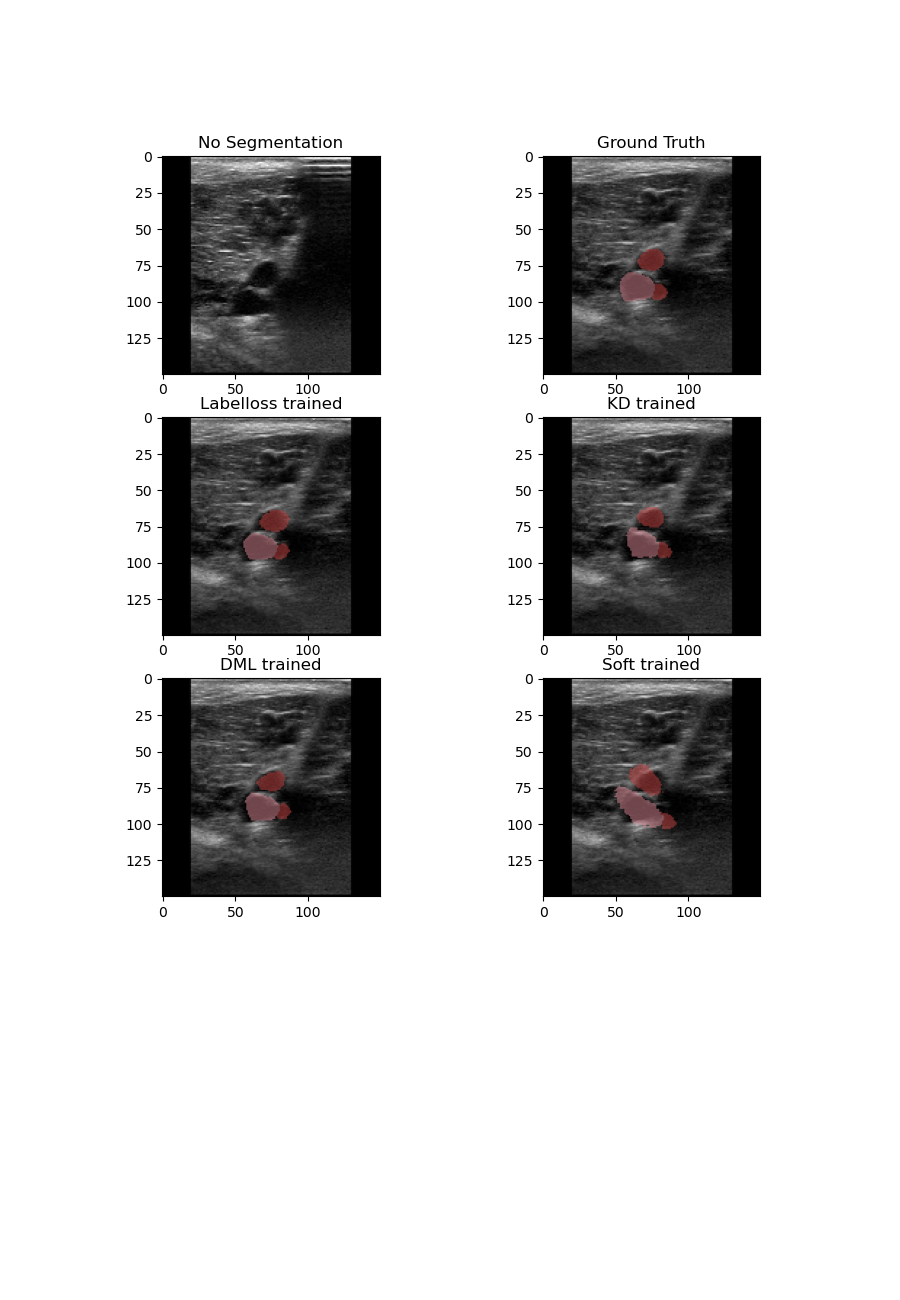

In [12]:
%matplotlib notebook

fig = plt.figure(figsize=(9,13))
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 2)
ax3 = fig.add_subplot(4, 2, 3)
ax4 = fig.add_subplot(4, 2, 4)
ax5 = fig.add_subplot(4, 2, 5)
ax6 = fig.add_subplot(4, 2, 6)

ax1.set_title('No Segmentation')
ax2.set_title('Ground Truth')
ax3.set_title('Labelloss trained')
ax4.set_title('KD trained')
ax5.set_title('DML trained')
ax6.set_title('Soft trained')


lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_classic = overlaySegment(frames[i], classic_segs[i].squeeze())
    overlay_kc = overlaySegment(frames[i], kc_segs[i].squeeze())
    overlay_dml = overlaySegment(frames[i], dml_segs[i].squeeze())
    overlay_soft = overlaySegment(frames[i], soft_segs[i].squeeze())
    
    no_seg_image = ax1.imshow(frames[i], cmap='gray', animated=True)
    no_seg_image = ax2.imshow(overlay_ground, animated=True)
    classic_image = ax3.imshow(overlay_classic, animated=True)
    kc_image = ax4.imshow(overlay_kc, animated=True)
    dml_image = ax5.imshow(overlay_dml, animated=True)
    soft_image = ax6.imshow(overlay_soft, animated=True)
    
    lines.append([no_seg_image,no_seg_image,classic_image, kc_image,dml_image, soft_image])
    
ani = animation.ArtistAnimation(fig,lines,interval=100,blit=True)
plt.show()

In [13]:
ani.save(f'all_compare{prob_id}.mp4')